In [2]:
!pip install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 19.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 51.8 MB/s eta 0:00:00


/tmp/ipykernel_3850/2002045547.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


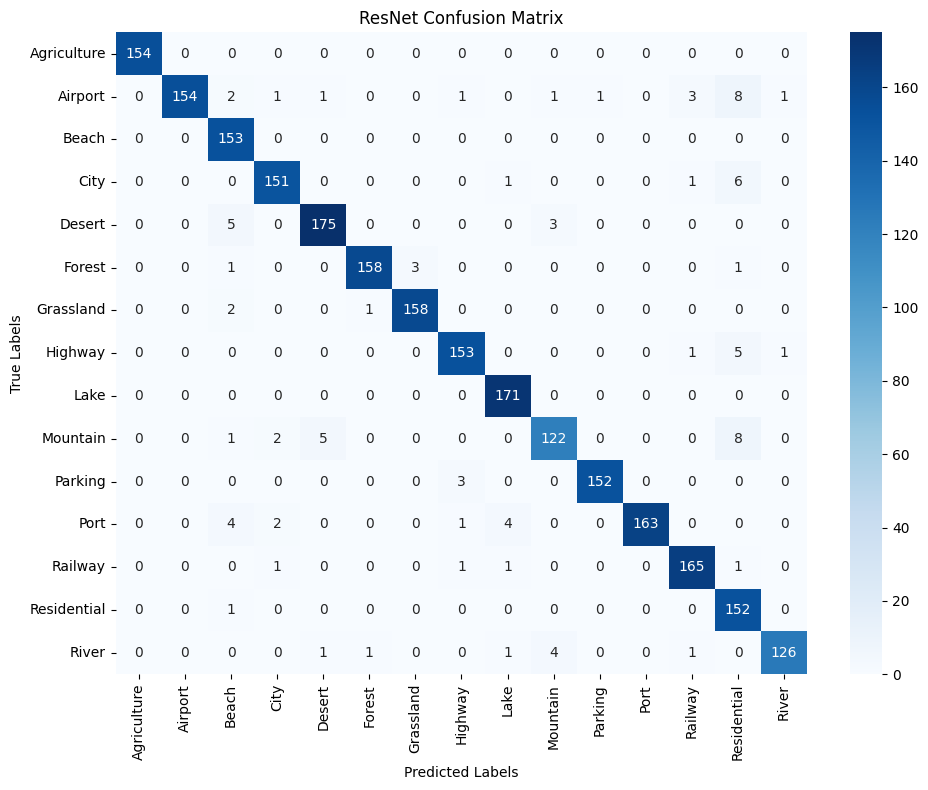

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn

DATA_DIR = '/root/Aerial_Landscapes'
MODEL_PATH = './resnet18.pth'
BATCH_SIZE = 32
NUM_CLASSES = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
val_size = int(0.2 * len(dataset))
_, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ResNet Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_resnet.png')
plt.show()